# Clustering

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
%reload_ext autoreload

In [43]:
#load env file
import os
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import OpenAI
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from azure.identity import DefaultAzureCredential

from llm.setup import create_azure_client
from functions.functions_cleancode import is_violent


## Data with embeddings

In [8]:
data_folder = Path("../data/embeddings")
file_to_open = data_folder / "embeddings.parquet"

df = pd.read_parquet(file_to_open)
display(df.head(5))

description = df["description"]

,description,embeddings
0,Øker kraftig: Setter inn ekstra buss. Antall b...,"[-0.006477916147559881, 0.05271952226758003, -..."
1,NRK-serien kalles «dokumentar». Men betalingen...,"[0.07025835663080215, 0.012009462341666222, -0..."
2,Har analysert alle avhørene av Viggo Kristians...,"[0.06529045104980469, 0.007411662023514509, -0..."
3,Åpner tilsynssak etter at barn døde. En famili...,"[-0.0183076374232769, 0.02547314576804638, -0...."
4,Bedret resultatet i krevende marked,"[0.052552178502082825, -0.03649456799030304, -..."


In [9]:
embeddings = np.vstack(df['embeddings'].values)

In [10]:
umap_reducer = UMAP(n_components=10, n_neighbors=5, min_dist=0.0, metric='cosine', random_state=42)
hdb_clusterer = HDBSCAN(min_cluster_size=3, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

topic_model = BERTopic(
  umap_model=umap_reducer,
  hdbscan_model=hdb_clusterer,
  language=None,
  calculate_probabilities=True,
)

# Train model
topic_model.fit(documents=description, embeddings=embeddings)

In [11]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,11,-1_to_etter_elroq_sør,"[to, etter, elroq, sør, nå, er, sin, den, feng...",[Grunnen var åpenbar. Det var en svært tydelig...
1,0,66,0_er_og_på_det,"[er, og, på, det, for, som, har, til, ikke, en]",[Totalrenoverte barndomshjemmet: – Det var til...
2,1,17,1_start_vant_og_mot,"[start, vant, og, mot, seier, det, en, for, di...",[Varsler endringer på laget. Nøkkelspiller uak...
3,2,11,2_millioner_for_har_vært,"[millioner, for, har, vært, misfornøyd, dessve...",[Legger ned bilbutikk: – Har vært en helt sinn...
4,3,11,3_e39_ap_vil_og,"[e39, ap, vil, og, for, til, på, er, bli, det]","[Her stenges veiene denne uka. Påska er over, ..."
5,4,9,4_baneheia_ingebrigtsen_var_viggo,"[baneheia, ingebrigtsen, var, viggo, kristians...",[Ble grillet: – Jeg var i tvil. Jan Helge Ande...
6,5,7,5_kristiansand_drept_personer_mot,"[kristiansand, drept, personer, mot, ble, tre,...",[Pappaen til Adeline (10): – Hun ble livredd. ...
7,6,6,6_varsler_på_frp_millioner,"[varsler, på, frp, millioner, kraftig, kan, me...",[Kraftig prishopp: – Helt jojo. Selv om det er...
8,7,6,7_krf_krfs_partiet_på,"[krf, krfs, partiet, på, et, ikke, stortinget,...","[– Hvis ikke det blir Stortinget til høsten, e..."
9,8,5,8_jeg_døde_farmasøyt_skrevet,"[jeg, døde, farmasøyt, skrevet, resepter, lege...",[Dødshjelp som helsetjeneste?. Jeg har vært sy...


## Remove stop words

In [12]:
vectorizer = CountVectorizer(min_df=3, ngram_range=(1, 4))

X = vectorizer.fit_transform(description)
word_counts = np.asarray(X.sum(axis=0)).flatten()
words = vectorizer.get_feature_names_out()
word_counts_sorted = np.argsort(word_counts)[::-1]
most_common_words = dict(zip(words[word_counts_sorted], word_counts[word_counts_sorted]))

print('Most common words:')
for word, count in list(most_common_words.items())[:25]:
    print(f'{word}: {count}')

# Make a list of the 10 most common words
stop_word_list = list(most_common_words.keys())[:25]

Most common words:
og: 84
er: 82
på: 81
det: 71
for: 68
til: 56
har: 51
en: 50
som: 48
av: 45
med: 37
at: 36
ikke: 31
etter: 31
et: 29
seg: 28
den: 27
om: 27
de: 26
jeg: 25
ble: 25
var: 25
han: 22
flere: 22
mot: 22


In [13]:
ctfidf_model = ClassTfidfTransformer(bm25_weighting=True) #Class Term Frequency-Inverse Document Frequency
vectorizer_model = CountVectorizer(min_df=3, ngram_range=(1, 4), stop_words=stop_word_list)

In [14]:
topic_model = BERTopic(
    umap_model=umap_reducer,
    hdbscan_model=hdb_clusterer,
    language=None,
    calculate_probabilities=True,
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model,
)

topics, probs = topic_model.fit_transform(documents=description, embeddings=embeddings)

In [15]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,11,-1_to_sin_nå_nye,"[to, sin, nå, nye, tatt, ha, kan, hundre, anke...",[21-åring skal ha svindlet sin egen farmor. Po...
1,0,66,0_du_vi_må_være,"[du, vi, må, være, meg, så, men, kristiansand,...",[Det er umulig å bygge 17.600 boliger uten å ø...
2,1,17,1_se_her_agder_onsdag,"[se, her, agder, onsdag, denne, under, opp, no...","[– Blytung tirsdag. Daniel Aase, Pål Wollebæk ..."
3,2,11,2_millioner_vært_fornøyd_også,"[millioner, vært, fornøyd, også, millioner kro...",[– Jeg har dessverre vært mer misfornøyd enn f...
4,3,11,3_vil_bli_få_denne uka,"[vil, bli, få, denne uka, her, norge, over, uk...",[– Her får vi klarsignal til å sette i gang. D...
5,4,9,4_jan helge_helge_jan_se,"[jan helge, helge, jan, se, da, der, fikk, hel...",[Ble grillet: – Jeg var i tvil. Jan Helge Ande...
6,5,7,5_kristiansand_tre_10_tatt,"[kristiansand, tre, 10, tatt, denne uka, uka, ...",[Pappaen til Adeline (10): – Hun ble livredd. ...
7,6,6,6_varsler_kan få_millioner kroner_millioner,"[varsler, kan få, millioner kroner, millioner,...",[Forslag ble nedstemt: – Henger ikke på greip....
8,7,6,7_stortinget_over_inn_mer,"[stortinget, over, inn, mer, mange, gjøre, ska...",[Skremmende likt politikk som vokser fram i US...
9,8,5,8_barn_ha_hun_ut,"[barn, ha, hun, ut, fram, livet, kan være, agd...",[Åpner tilsynssak etter at barn døde. En famil...


## Add representation model

In [16]:
custom_prompt = """
Jeg har et emne som inneholder følgende dokumenter: 
[DOCUMENTS]
Emnet er beskrevet av følgende nøkkelord: [KEYWORDS]
Svaret skal være konsist, kort og gi en oversikt over emnet.
Basert på dette, gi en kort beskrivelse for emnet med 3 til 4 ord. Unngå voldelige uttrykk.
<emnebeskrivelse>
"""

In [22]:
#Remember to run az login

# Set up the Azure OpenAI client
client = create_azure_client(async_mode=False)

# Create your representation model
representation_model = OpenAI(client,chat=True, model='gpt-4.1', prompt=custom_prompt, nr_docs=15)

In [23]:
sample = df.sample(1)['description'].values[0]
print(sample)

Anniken Binz rødmet bare hun skulle si navnet sitt. Rådene til deg som er nervøs for å holde tale og foredrag.. – Hvis positive tanker hadde løst problemet, hadde ingen hatt prestasjonsangst, sier psykolog.


In [24]:
# create dict with questions and answers ChatCompletionMessageParam to test client
messages = [
    {
        "role": "system",
        "content": custom_prompt
    },
    {
        "role": "user",
        "content": sample,
    }
]
result = client.chat.completions.create(model="gpt-4.1", messages=messages)

In [25]:
print(result.choices[0].message.content)

Prestasjon, nervøsitet, taletips


## Check Content Safety

In [ ]:
# Check if the sample text is violent
is_sample_violent = is_violent(text=sample, threshold=0.5, credential=DefaultAzureCredential())
print(f"Is the sample text violent? {is_sample_violent}")

Is the sample text violent? False


In [ ]:
# Check Content Safety for all descriptions and mask violent rows
from tqdm.auto import tqdm

df["description"] = df["description"].astype(str)

for idx, text in enumerate(tqdm(df["description"], desc="Masking violent rows")):
   try:
       if is_violent(text):
           df.at[idx, "description"] = "Filtrert bort pga. innhold"
   except Exception as e:
       print(f"Error at row {idx}: {e}")

In [ ]:
# Save masked DataFrame to parquet
df.to_parquet("../data/descriptions_masked.parquet", index=False)

In [46]:
#get the df from the parquet file - avoid running the is_violent function again
df = pd.read_parquet("../data/descriptions_masked.parquet")
description = df["description"]
display(df.head(5))

,description,embeddings
0,Øker kraftig: Setter inn ekstra buss. Antall b...,"[-0.006477916147559881, 0.05271952226758003, -..."
1,Filtrert bort pga. innhold,"[0.07047104835510254, 0.01057265605777502, -0...."
2,Filtrert bort pga. innhold,"[0.06529473513364792, 0.007358599454164505, -0..."
3,Filtrert bort pga. innhold,"[-0.0183076374232769, 0.02547314576804638, -0...."
4,Bedret resultatet i krevende marked,"[0.052552178502082825, -0.03649456799030304, -..."


## Combine
Filtered descriptions and representation model.

In [47]:
#fit new model with masked descriptions
topic_model.fit(documents=description, embeddings=embeddings)

In [48]:
#use representation model on the new model
topic_model.update_topics(docs=description, representation_model=representation_model)

In [49]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,11,"-1_Beredskap, bilnyheter, samfunnsnytt","[Beredskap, bilnyheter, samfunnsnytt]","[Filtrert bort pga. innhold, Billigste el-fire..."
1,0,66,"0_Lokalsamfunn, identitet, livsstil, bygdeutvi...","[Lokalsamfunn, identitet, livsstil, bygdeutvik...",[Når vi 20 grader? – Mest sannsynlig. Først må...
2,1,17,1_Sørlandsfotball og sportsnyheter,[Sørlandsfotball og sportsnyheter],"[Filtrert bort pga. innhold, Filtrert bort pga..."
3,2,11,"2_Konkurs, overskudd og næringsliv","[Konkurs, overskudd og næringsliv]","[Selges for 1,5 millioner: 40 sengeplasser og ..."
4,3,11,"3_Samferdsel, politikk og samfunn","[Samferdsel, politikk og samfunn]","[Filtrert bort pga. innhold, – Vi er nødt til ..."
5,4,9,4_Rettssaker og vitnemål,[Rettssaker og vitnemål],"[Filtrert bort pga. innhold, Filtrert bort pga..."
6,5,7,5_Politiaksjoner og arrangementer Kristiansand,[Politiaksjoner og arrangementer Kristiansand],"[Filtrert bort pga. innhold, Filtrert bort pga..."
7,6,6,6_Energipriser og bøter,[Energipriser og bøter],[Forslag ble nedstemt: – Henger ikke på greip....
8,7,6,7_KrFs skolepolitikk og mangfold,[KrFs skolepolitikk og mangfold],[Høyres “frie skolevalg” er ikke ekte frihet. ...
9,8,5,8_Eldreomsorg og legemiddelbruk,[Eldreomsorg og legemiddelbruk],"[Filtrert bort pga. innhold, Filtrert bort pga..."


In [50]:
docs_with_cluster = topic_model.get_document_info(docs=description)
docs_with_cluster["id"] = df.index
docs_with_cluster.set_index("id", inplace=True)
docs_with_cluster["cluster"] = docs_with_cluster["Topic"]

#Store as parquet
docs_with_cluster.to_parquet("../data/descriptions_with_clusters.parquet")
display(docs_with_cluster.head())

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,cluster
id,,,,,,,,,
0,Øker kraftig: Setter inn ekstra buss. Antall b...,3,"3_Samferdsel, politikk og samfunn","[Samferdsel, politikk og samfunn]","[Filtrert bort pga. innhold, – Vi er nødt til ...","Samferdsel, politikk og samfunn",0.366949,False,3
1,Filtrert bort pga. innhold,0,"0_Lokalsamfunn, identitet, livsstil, bygdeutvi...","[Lokalsamfunn, identitet, livsstil, bygdeutvik...",[Når vi 20 grader? – Mest sannsynlig. Først må...,"Lokalsamfunn, identitet, livsstil, bygdeutvikling",1.000000,True,0
2,Filtrert bort pga. innhold,4,4_Rettssaker og vitnemål,[Rettssaker og vitnemål],"[Filtrert bort pga. innhold, Filtrert bort pga...",Rettssaker og vitnemål,0.553104,True,4
3,Filtrert bort pga. innhold,8,8_Eldreomsorg og legemiddelbruk,[Eldreomsorg og legemiddelbruk],"[Filtrert bort pga. innhold, Filtrert bort pga...",Eldreomsorg og legemiddelbruk,1.000000,True,8
4,Bedret resultatet i krevende marked,2,"2_Konkurs, overskudd og næringsliv","[Konkurs, overskudd og næringsliv]","[Selges for 1,5 millioner: 40 sengeplasser og ...","Konkurs, overskudd og næringsliv",0.491429,False,2


## Visualization

In [51]:
two_dim_embeddings = UMAP(n_components=2, n_neighbors=15, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

In [52]:
topics_to_visualize = topic_model.get_topic_freq().head(30).Topic.to_list()

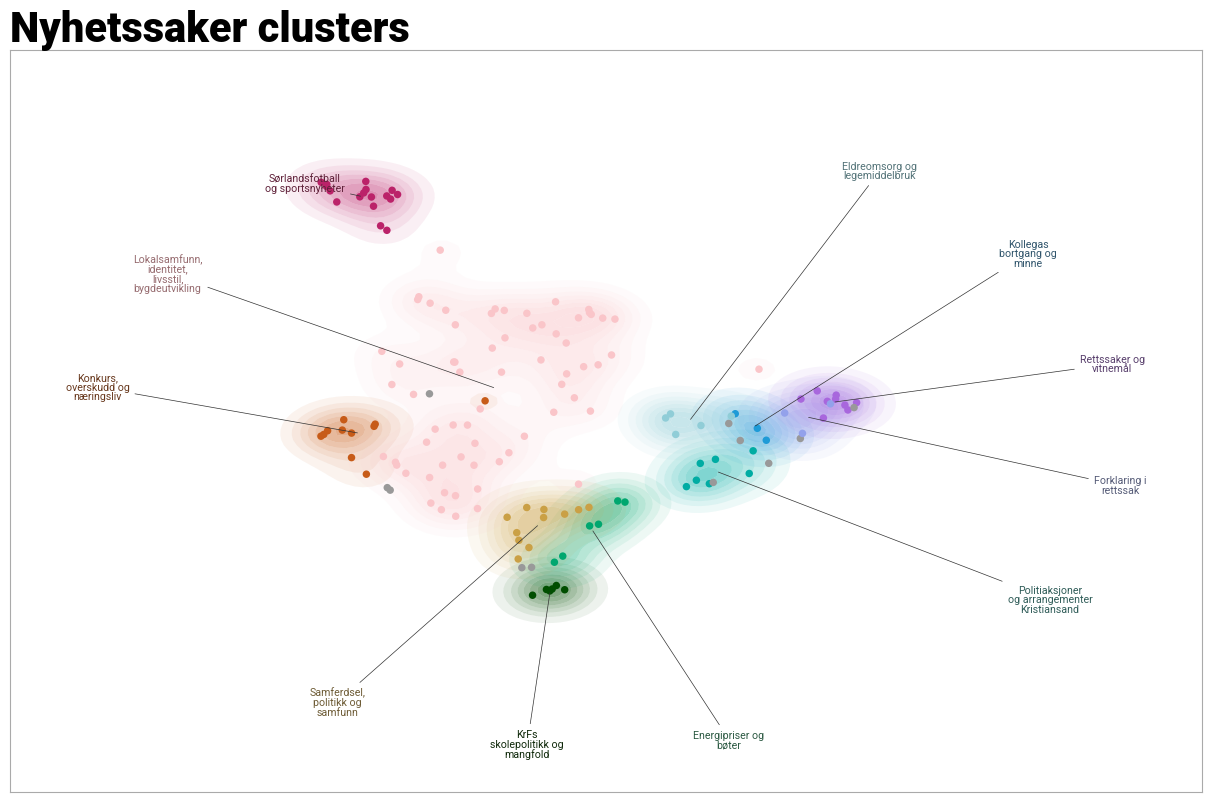

In [53]:
fig = topic_model.visualize_document_datamap(docs=description, embeddings=embeddings, reduced_embeddings=two_dim_embeddings, topics=topics_to_visualize, title="Nyhetssaker clusters")

<InteractiveFigure width=1200 height=750>
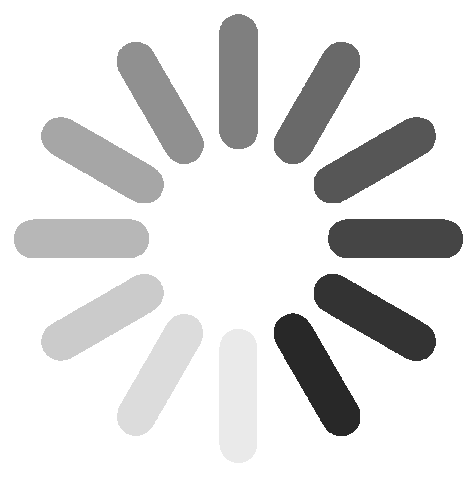

In [54]:
topic_model.visualize_document_datamap(docs=description, embeddings=embeddings, reduced_embeddings=two_dim_embeddings, topics=topics_to_visualize, title="Nyhetssaker clusters", interactive=True)